# Implementation of the Moho inversion algorithm

This notebook presents a Python class that implements the proposed method. We'll use the [inverse problems framework](http://www.fatiando.org/api/inversion.html) of the library [Fatiando a Terra](http://www.fatiando.org). The class `MohoGravityInvSpherical` is defined in the [`mohoinv.py`](mohoinv.py) file.

## Package imports

In [1]:
# Insert plots into the notebook
%matplotlib inline

In [2]:
from __future__ import division, unicode_literals
import numpy as np
import multiprocessing
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn  # Makes the default style of the plots nicer

Load the required modules from Fatiando a Terra and show the specific version of the library used.

In [3]:
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import utils, gridder
import fatiando

In [4]:
print("Using Fatiando a Terra version: {}".format(fatiando.__version__))

Using Fatiando a Terra version: 0.4


In [5]:
from mohoinv import TesseroidRelief, MohoGravityInvSpherical, make_mesh

Get the number of cores in the computer to run the forward modeling in parallel.

In [6]:
ncpu = multiprocessing.cpu_count()
ncpu

4

## Test the class on simple synthetic data

We can test and show how the class works on some simple synthetic data. We'll use the example model from the [tesseroid-relief-example.ipynb](tesseroid-relief-example.ipynb) notebook.

First, make the model of the Moho.

In [7]:
# shape is nlat, nlon = the number of points in the grid
shape = (30, 30)
# Make a regular grid inside an area = (s, n, w, e)
area = (20, 60, -40, 40)
lat, lon, h = gridder.regular(area, shape, z=250e3)
# Make a checkerboard relief undulating along the -35km height reference
f = 0.15
reference = -35e3
relief = 10e3*np.sin(1.5*f*lon)*np.cos(f*lat) + reference
# The density contrast is negative if the relief is below the reference
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

In [8]:
model = make_mesh(area, shape, relief, reference)
model.addprop('density', density)

(19.310344827586206, 59.310344827586206)

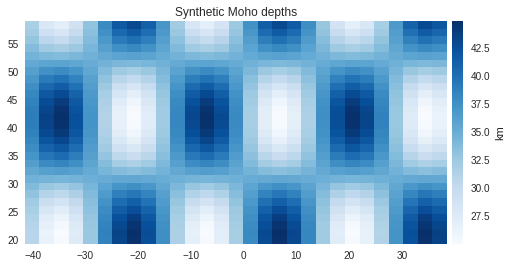

In [9]:
plt.figure(figsize=(9, 4))
plt.title("Synthetic Moho depths")
plt.pcolormesh(model.lons, model.lats, -0.001*model.relief.reshape(model.shape), 
               cmap='Blues')
plt.colorbar(pad=0.01).set_label('km')
plt.xlim(model.lons.min(), model.lons.max())
plt.ylim(model.lats.min(), model.lats.max())

Now, generate some synthetic data by forward modeling.

In [10]:
gz = tesseroid.gz(lon, lat, h, model, njobs=ncpu)

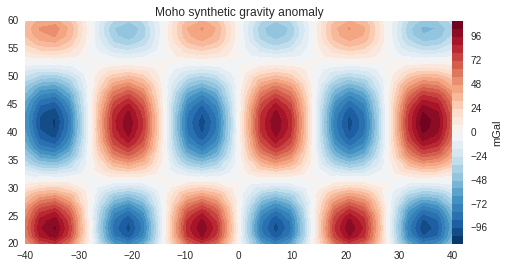

In [11]:
plt.figure(figsize=(9, 4))
plt.title('Moho synthetic gravity anomaly')
plt.tricontourf(lon, lat, gz, 30, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')

## Run the inversion

For this test, we'll use a mesh with the same dimensions and the original model.

In [12]:
mesh = model.copy(deep=True)
mesh.props['density'] = 600*np.ones(mesh.size)

Create the solver object.

In [13]:
solver = MohoGravityInvSpherical(lat, lon, h, gz, mesh, njobs=ncpu)

Configure the optimization method to Gauss-Newton and set the initial estimate.

In [14]:
initial = np.ones(solver.nparams)*(mesh.reference - 30e3)
solver.config('newton', initial=initial, tol=0.2, maxit=10)

Run the inversion and time the computation.

In [15]:
%time solver.fit()

CPU times: user 72 ms, sys: 20 ms, total: 92 ms
Wall time: 18.8 s


/home/leo/bin/anaconda/envs/moho/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)


Plot the RMS error (Root Mean Square) per iteration to get an idea of the convergence of the method.

In [16]:
rms = np.sqrt(solver.stats_['objective'])/np.sqrt(solver.ndata)

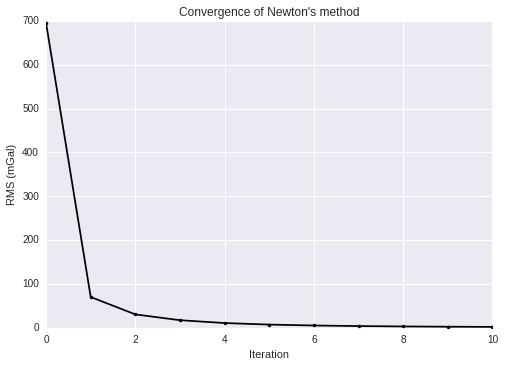

In [17]:
plt.figure()
ax = plt.subplot(111)
ax.set_title('Convergence of {}'.format(solver.stats_['method']))
ax.plot(rms, '.k-')
ax.set_ylabel('RMS (mGal)')
ax.set_xlabel('Iteration')

Plot the data misfit and residuals

In [18]:
predicted = solver.predicted()
residuals = solver.residuals()

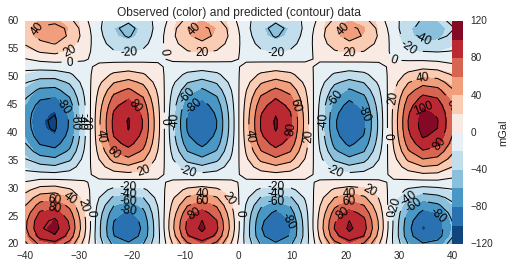

In [19]:
plt.figure(figsize=(9, 4))
levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')
mpl.contour(lon, lat, predicted, shape, levels)
plt.title('Observed (color) and predicted (contour) data')

Mean: 0.214036548333   std: 2.02563704196


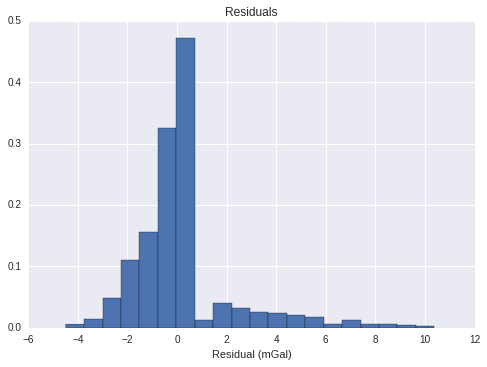

In [20]:
plt.title('Residuals')
plt.hist(residuals, bins=20, normed=True)
plt.xlabel('Residual (mGal)')
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

Map the estimated Moho depth.

In [21]:
moho = solver.estimate_

(19.310344827586206, 59.310344827586206)

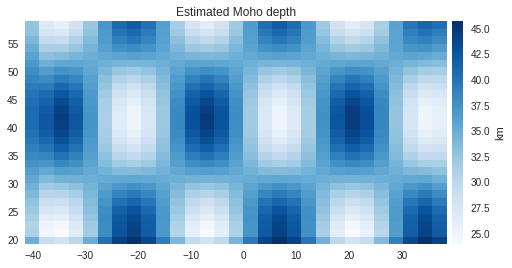

In [22]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
plt.pcolormesh(moho.lons, moho.lats, -0.001*moho.relief.reshape(moho.shape), 
               cmap='Blues')
plt.colorbar(pad=0.01).set_label('km')
plt.xlim(moho.lons.min(), moho.lons.max())
plt.ylim(moho.lats.min(), moho.lats.max())